## **1. Importing packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
from sklearn.compose import make_column_transformer
from sklearn.metrics import RocCurveDisplay, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from itertools import product

## **2. Importing data**

In [2]:
loans_backup = pd.read_csv("Loan_status_2007-2020Q3.gzip")

C:\Users\HARDPC\AppData\Local\Temp\ipykernel_13808\626459721.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  loans_backup = pd.read_csv("Loan_status_2007-2020Q3.gzip")


In [3]:
loans = loans_backup.copy()

## **3. Data preprocessing**

### 3.1 First look at the data

In [4]:
pd.options.display.max_rows = None

In [5]:
pd.options.display.max_columns = None

In [6]:
inn_size = loans.size
inn_size

415420006

In [7]:
loans.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,0.0,0.0,3

In [8]:
loans.tail()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2925488,105446,102556443,24000.0,24000.0,24000.0,60 months,23.99%,690.30,E,E2,Senior Escrow Officer,< 1 year,RENT,107000.0,Source Verified,Apr-2017,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,other,Other,801xx,CO,11.65,3.0,Apr-1995,670.0,674.0,1.0,4.0,73.0,13.0,2.0,9688.0,24.9%,24.0,f,0.0,0.0,7749.830000,7749.83,2561.41,5188.42,0.00,0.00,0.0000,Mar-2018,690.30,NaN,May-2020,504.0,500.0,1.0,8.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,60812.0,2.0,1.0,1.0,3.0,4.0,51124.0,NaN,1.0,5.0,3454.0,25.0,38900.0,1.0,0.0,2.0,8.0,5528.0,20859.0,26.0,1.0,0.0,90.0,263.0,6.0,4.0,0.0,18.0,NaN,4.0,4.0,1.0,4.0,7.0,6.0,11.0,5.0,12.0,18.0,7.0,13.0,0.0,0.0,1.0,2.0,87.5,0.0,1.0,1.0,103322.0,60812.0,28200.0,64422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2925489,105447,102653304,10000.0,10000.0,10000.0,36 months,7.99%,313.32,A,A5,Rn,10+ years,MORTGAGE,65000.0,Source Verified,Apr-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,187xx,PA,19.55,1.0,Sep-1993,725.0,729.0,0.0,12.0,NaN,15.0,0.0,9751.0,15.7%,27.0,w,0.0,0.0,11233.834658,11233.83,10000.00,1233.83,0.00,0.00,0.0000,Oct-2019,2151.99,NaN,Oct-2019,769.0,765.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,55863.0,1.0,2.0,0.0,0.0,45.0,46112.0,50.0,2.0,3.0,3043.0,20.0,62100.0,0.0,0.0,0.0,3.0,3724.0,26229.0,24.6,0.0,0.0,154.0,282.0,1.0,1.0,0.0,1.0,12.0,17.0,12.0,0.0,4.0,8.0,7.0,12.0,4.0,13.0,23.0,8.0,15.0,0.0,0.0,0.0,2.0,92.6,14.3,0.0,0.0,132303.0,55863.0,34800.0,70203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2925490,105448,102628603,10050.0,10050.0,10050.0,36 months,16.99%,358.26,D,D1,Sales Associat

In [9]:
# Dropping Unnamed column and setting index to id
loans.drop(columns="Unnamed: 0", inplace=True)
loans.set_index("id", inplace=True)

In [10]:
len(loans.columns.values)

140

In [11]:
loans.isnull().sum()

loan_amnt                                           1
funded_amnt                                         1
funded_amnt_inv                                     1
term                                                1
int_rate                                            1
installment                                         1
grade                                               1
sub_grade                                           1
emp_title                                      264087
emp_length                                     205221
home_ownership                                      1
annual_inc                                          5
verification_status                                 1
issue_d                                             1
loan_status                                         1
pymnt_plan                                          1
url                                                 1
purpose                                             1
title                       

In [12]:
# Dropping all observations that doesn't have 'loan_amnt' filled

loans = loans[~np.isnan(loans["loan_amnt"])].copy()

### 3.3 Dropping column having > 50% values missing

Some features has a lot of missing values, thus those with more than 50% of missing values will be removed. Firstly, the dataframe with amount of missing values as a percentage of number of observations is created, and based on the result, columns is removed or not.

In [13]:
miss_val_columns = pd.DataFrame(
    round((loans.isna().sum() / (loans.count() + loans.isna().sum()) * 100), 2),
    columns=["perc_miss_val"]
)

In [14]:
miss_val_columns = miss_val_columns.reset_index().rename(columns={"index": "column"})

In [15]:
miss_val_columns

,column,perc_miss_val
0,loan_amnt,0.00
1,funded_amnt,0.00
2,funded_amnt_inv,0.00
3,term,0.00
4,int_rate,0.00
5,installment,0.00
6,grade,0.00
7,sub_grade,0.00
8,emp_title,9.03
9,emp_length,7.01


In [16]:
loans.drop(columns=miss_val_columns[miss_val_columns["perc_miss_val"] >= 50]["column"].to_list(), inplace=True)

In [17]:
len(loans.columns.values)

105

### **3.4 Data cleaning and transforming related to datatypes**

#### **3.4.1 Defaulted and not defaulted**

To see how variables impact defaulting `loan_status` column needs to be updated and correctly indicate weather client defaulted or not. Approximately 13% of clients in the database is labeled as defaulted with number 0 assigned, and 87% as not defaulted with number 1 assigned.

In [18]:
loans["loan_status"].value_counts(normalize=True)

loan_status
Fully Paid                                             0.511976
Current                                                0.352425
Charged Off                                            0.123927
Late (31-120 days)                                     0.005522
In Grace Period                                        0.003428
Late (16-30 days)                                      0.000929
Issued                                                 0.000705
Does not meet the credit policy. Status:Fully Paid     0.000680
Does not meet the credit policy. Status:Charged Off    0.000260
Default                                                0.000148
Name: proportion, dtype: float64

In [19]:
loans["loan_status"] = np.where(
    loans["loan_status"].isin([
        "Charged Off",
        "Late (31-120 days)",
        "Does not meet the credit policy. Status:Charged Off",
        "Default"
    ]),
    0,
    1
)    

In [20]:
loans["loan_status"].value_counts(normalize=True)

loan_status
1    0.870143
0    0.129857
Name: proportion, dtype: float64

In [21]:
loans.rename(columns={"loan_status": "good_bad"}, inplace=True)

#### **3.4.2 Transforming variables and correcting datatypes**

In [22]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925492 entries, 1077501 to 99799684
Columns: 105 entries, loan_amnt to debt_settlement_flag
dtypes: float64(81), int32(1), object(23)
memory usage: 2.3+ GB


In [23]:
loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,good_bad,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,1,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,May-2020,704.0,700.0,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N
1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,0,n,https://lendingclub.com/browse/loanDetail.acti...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,Oct-2016,499.0,0.0,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N
1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,1,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-2014,649.91,Jun-2017,739.0,735.0,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N
1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,1,n,https://lendingclub.com/browse/loanDetail.acti...,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-2015,357.48,Apr-2016,604.0,600.0,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N
1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical

#### **Date variables**

Following columns have date values and need to be transformed to "months since" variable:

* `earliest_cr_line`
* `last_pymnt_d`
* `last_credit_pull_d`
* `issue_d`

There are 29 missing values in this column, however, this column is not needed for model. This column is only important for calculating number of months since last credit card, and number of months will be continuous variable, thus it will be easier to fill missing values there

In [24]:
loans["earliest_cr_line"].dtypes

dtype('O')

In [25]:
date_cols = ["earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "issue_d"]

In [26]:
for col in date_cols:
    loans[col] = pd.to_datetime(loans[col], format="%b-%Y")

In [27]:
loans["earliest_cr_line"].max()

Timestamp('2017-07-01 00:00:00')

Max timestamp of the data is at 2020-12-01, so let's say that we analyze the data in 2020-12-02 and this will be our benchmark.

In [28]:
date_bench = pd.to_datetime("2020-12-02")

In [29]:
(date_bench - loans["earliest_cr_line"]).head()

id
1077501   13119 days
1077430    7916 days
1077175    6971 days
1076863    9071 days
1075358    9102 days
Name: earliest_cr_line, dtype: timedelta64[ns]

In [30]:
for col in date_cols:

    loans["mnths_since_" + col] = ((date_bench - loans[col]).dt.days) / 30

In [31]:
loans.drop(columns=date_cols, inplace=True)

In [32]:
loans[["mnths_since_earliest_cr_line", "mnths_since_last_pymnt_d", "mnths_since_last_credit_pull_d", "mnths_since_issue_d"]].describe()

,mnths_since_earliest_cr_line,mnths_since_last_pymnt_d,mnths_since_last_credit_pull_d,mnths_since_issue_d
count,2.925463e+06,2.920571e+06,2.925417e+06,2.925492e+06
mean,2.458225e+02,2.626303e+01,1.531520e+01,4.670369e+01
std,9.726803e+01,2.222935e+01,1.451867e+01,2.566869e+01
min,4.166667e+01,3.333333e-02,2.066667e+00,3.066667e+00
25%,1.806000e+02,7.166667e+00,7.166667e+00,2.540000e+01
50%,2.303333e+02,1.936667e+01,7.166667e+00,4.370000e+01
75%,2.973333e+02,4.063333e+01,1.833333e+01,6.396667e+01
max,1.068433e+03,1.583333e+02,1.654667e+02,1.644333e+02


#### **Text variables**

Following variables have text values and need to be transformed:

* `int_rate` -> remove "%" sign and change to float
* `term` -> remove "months" and change to int
* `emp_length` -> remove "years" and additional signs and change to int
* `revol_util` -> remove "%" sign and change to float

Following redundant variables will be dropped:

* `url` (it's just link to loan data on the internet)
* `zip_code` (there is `addr_state` column, which will be better for analysis)

Following variables will be transformed to be lowercased and will have following and trailing spaces removed:

* `purpose`
* `title`
* `addr_state`
* `emp_title`
* `home_ownership`
* `verification_status`
* `pymnt_plan`
* `initial_list_status`
* `hardship_flag`
* `debt_settlement_flag`

**Dropping columns**

In [33]:
loans.drop(columns=["url", "zip_code"], inplace=True)

**Removing % signs and changing two variables:**

In [34]:
for col in ["int_rate", "revol_util"]:
    loans[col] = loans[col].str.rstrip("%").astype(float)

**Removing "months" from `term` and changing to int**

In [35]:
loans["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [36]:
loans["term"] = (loans["term"]
                 .str.lstrip()
                 .str.replace(" months", "")
                 .astype(int)
                )

In [37]:
loans["term"].unique()

array([36, 60])

**Transforming and investigating other text columns:**

In [38]:
text_cols = [
    "purpose",
    "title",
    "addr_state",
    "emp_title",
    "home_ownership",
    "verification_status",
    "pymnt_plan",
    "initial_list_status",
    "application_type",
    "hardship_flag",
    "debt_settlement_flag"
]

In [39]:
for col in text_cols:
    print(f"{col} \n")
    loans[col] = loans[col].str.lower().str.strip()
    print(f"unique values: {loans[col].nunique()}\n")
    print(loans[col].unique())
    print("\n\n")

purpose 

unique values: 14

['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']



title 

unique values: 51791

['computer' 'bike' 'real estate business' ... 'new kitchen for momma!'
 'new baby and new house (cc consolidate)' 'credit card/auto repair']



addr_state 

unique values: 51

['az' 'ga' 'il' 'ca' 'or' 'nc' 'tx' 'va' 'mo' 'ct' 'ut' 'fl' 'ny' 'pa'
 'mn' 'nj' 'ky' 'oh' 'sc' 'ri' 'la' 'ma' 'wa' 'wi' 'al' 'co' 'ks' 'nv'
 'ak' 'md' 'wv' 'vt' 'mi' 'dc' 'sd' 'nh' 'ar' 'nm' 'mt' 'hi' 'wy' 'ok'
 'de' 'ms' 'tn' 'ia' 'ne' 'id' 'in' 'me' 'nd']



emp_title 

unique values: 470081

[nan 'ryder' 'air resources board' ... 'track repair'
 'emr applications tech' 'contact input']



home_ownership 

unique values: 6

['rent' 'own' 'mortgage' 'other' 'none' 'any']



verification_status 

unique values: 3

['verified' 'source verified' 'not verified']



pymn

In [40]:
loans["title"].value_counts().head(20)

title
debt consolidation           1535986
credit card refinancing       648801
home improvement              182729
other                         165855
major purchase                 57393
medical expenses               33310
car financing                  26343
business                       26209
vacation                       19323
home buying                    18193
moving and relocation          17590
consolidation                   8142
debt consolidation loan         4824
credit card consolidation       3661
personal loan                   3418
consolidation loan              2691
credit card payoff              2574
credit card refinance           2539
consolidate                     2190
personal                        2154
Name: count, dtype: int64

In [41]:
loans["emp_title"].value_counts().head(20)

emp_title
teacher               62223
manager               58549
owner                 37704
registered nurse      30632
driver                29020
supervisor            28454
sales                 23137
rn                    21477
office manager        18863
project manager       18036
general manager       17622
truck driver          17323
director              13347
president             11553
engineer              11087
sales manager         11002
operations manager    10902
police officer         9940
technician             9580
vice president         9579
Name: count, dtype: int64

All columns seems good, but:
* `pymnt_plan` can be dropped, beacause it has only one value
* `title` can be dropped, because the same information can be found in `purpose` column, which is cleaned

In [42]:
loans.drop(columns=["emp_title"], inplace=True)

#### **3.4.3 Removing correlated features**

#### **Numeric variables**

In [43]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [44]:
loans_corr = loans[loans.select_dtypes(numerics).columns.values].corr().round(2) * 100

In [45]:
loans_corr_85 = loans_corr >= 85

In [46]:
loans_corr_cols = pd.DataFrame(loans_corr_85.dot(loans_corr_85.columns + ';').str.rstrip(';'), columns=["columns with >=85 corr"])

In [47]:
loans_corr_cols["columns with >=85 corr"] = loans_corr_cols["columns with >=85 corr"].str.replace(";", ", ")

In [48]:
pd.options.display.max_columns = None

In [49]:
pd.set_option('display.max_colwidth', None)
loans_corr_cols

,columns with >=85 corr
loan_amnt,"loan_amnt, funded_amnt, funded_amnt_inv, installment"
funded_amnt,"loan_amnt, funded_amnt, funded_amnt_inv, installment"
funded_amnt_inv,"loan_amnt, funded_amnt, funded_amnt_inv, installment"
term,term
int_rate,int_rate
installment,"loan_amnt, funded_amnt, funded_amnt_inv, installment"
annual_inc,annual_inc
good_bad,good_bad
dti,dti
delinq_2yrs,delinq_2yrs


In [50]:
loans_corr_cols["columns with >=85 corr"] = loans_corr_cols["columns with >=85 corr"].str.split(',')

In [51]:
correlated_features = [
    ['loan_amnt', ' funded_amnt', ' funded_amnt_inv', ' installment'],
    ['fico_range_low', ' fico_range_high'],
    ['open_acc', ' num_sats'],
    ['revol_util', ' bc_util', ' percent_bc_gt_75'],
    ['out_prncp', ' out_prncp_inv'],
    ['total_pymnt', ' total_pymnt_inv', ' total_rec_prncp'],
    ['recoveries', ' collection_recovery_fee'],
    ['tot_cur_bal', ' tot_hi_cred_lim'],
    ['total_bal_il', ' total_bal_ex_mort', ' total_il_high_credit_limit'],
    ['last_fico_range_high', ' last_fico_range_low'],
    ['mo_sin_old_rev_tl_op', ' mnths_since_earliest_cr_line'],
    ['num_actv_rev_tl', ' num_rev_tl_bal_gt_0'],
    ['bc_open_to_buy', ' total_bc_limit'],
    ['mnths_since_last_pymnt_d', ' mnths_since_issue_d']
]

for corr_cols in correlated_features:
    print(loans[[c.strip() for c in corr_cols]].isnull().sum(), "\n")
    

loan_amnt          0
funded_amnt        0
funded_amnt_inv    0
installment        0
dtype: int64 

fico_range_low     0
fico_range_high    0
dtype: int64 

open_acc       29
num_sats    58590
dtype: int64 

revol_util           2660
bc_util             84141
percent_bc_gt_75    83149
dtype: int64 

out_prncp        0
out_prncp_inv    0
dtype: int64 

total_pymnt        0
total_pymnt_inv    0
total_rec_prncp    0
dtype: int64 

recoveries                 0
collection_recovery_fee    0
dtype: int64 

tot_cur_bal        70276
tot_hi_cred_lim    70276
dtype: int64 

total_bal_il                  866129
total_bal_ex_mort              50030
total_il_high_credit_limit     70276
dtype: int64 

last_fico_range_high    0
last_fico_range_low     0
dtype: int64 

mo_sin_old_rev_tl_op            70277
mnths_since_earliest_cr_line       29
dtype: int64 

num_actv_rev_tl        70276
num_rev_tl_bal_gt_0    70276
dtype: int64 

bc_open_to_buy    82668
total_bc_limit    50030
dtype: int64 

mnths_since

Columns that will be dropped:

* `funded_amnt`
* `funded_amnt_inv`
* `installment`
* `fico_range_high`
* `bc_util`
* `out_prncp_inv`
* `total_pymnt_inv`
* `total_rec_prncp`
* `collection_recovery_fee`
* `last_fico_range_high`
* `tot_cur_bal`
* `total_bal_il`
* `total_il_high_credit_limit`
* `bc_open_to_buy`
* `percent_bc_gt_75`
* `mo_sin_old_rev_tl_op`
* `num_stats`
* `mnths_since_last_pymnt_d`

In [52]:
loans.drop(columns=[
    "funded_amnt",
    "funded_amnt_inv",
    "installment",
    "fico_range_high",
    "bc_util",
    "out_prncp_inv",
    "total_pymnt_inv",
    "total_rec_prncp",
    "collection_recovery_fee",
    "last_fico_range_high",
    "tot_cur_bal",
    "total_bal_il",
    "total_il_high_credit_limit",
    "bc_open_to_buy",
    "percent_bc_gt_75",
    "mo_sin_old_rev_tl_op",
    "num_sats",
    "mnths_since_last_pymnt_d"
], inplace=True)

In [53]:
len(loans.columns.values)

84

In [54]:
for col in loans.columns.values:
    if col != "emp_title":
        sns.scatterplot(x=col, y="int_rate", data=loans).set(title=f"int_rate vs {col}", xlabel=col, ylabel="int_rate")
        plt.show()

In [55]:
loans = loans[
    (loans["annual_inc"] < 0.2 * np.power(10, 8)) &
    (loans["revol_util"] < 300) &
    (loans["acc_now_delinq"] < 10) &
    (loans["tot_coll_amt"] < 2 * np.power(10, 6)) &
    (loans["open_il_12m"] < 17) &
    (loans["open_il_24m"] < 35) &
    (loans["il_util"] < 700) & 
    (loans["max_bal_bc"] < 0.7 * np.power(10, 6)) &
    (loans["total_rev_hi_lim"] < 0.3 * np.power(10, 7)) &
    (loans["total_cu_tl"] < 90) &
    (loans["delinq_amnt"] < 150000) &
    (loans["mort_acc"] < 60) &
    (loans["num_tl_90g_dpd_24m"] < 50) &
    (loans["tax_liens"] < 70) &
    (loans["total_bc_limit"] < 1.0 * np.power(10, 6))
].copy()

## **4 Data preparation for modelling**

### **4.1 Imputing missing values with SimpleImputer**

In [56]:
loans[[
    "grade",
    "sub_grade",
    "emp_length",
    "home_ownership",
    "verification_status",
    "pymnt_plan",
    "purpose",
    "title",
    "addr_state",
    "initial_list_status",
    "application_type",
    "hardship_flag",
    "debt_settlement_flag"
]] = loans[[
    "grade",
    "sub_grade",
    "emp_length",
    "home_ownership",
    "verification_status",
    "pymnt_plan",
    "purpose",
    "title",
    "addr_state",
    "initial_list_status",
    "application_type",
    "hardship_flag",
    "debt_settlement_flag"
]].astype("category")

In [57]:
X = loans.drop(columns=["good_bad"])
y = loans.loc[:, "good_bad"]

In [58]:
cat_ids = (X.dtypes == "category")

In [59]:
cat_columns = X.columns[cat_ids].tolist()

In [60]:
num_columns = X.columns[~cat_ids].tolist()

In [61]:
imputer_categoric = SimpleImputer(strategy="most_frequent")

In [62]:
imputer_numeric = SimpleImputer(strategy="median")

In [63]:
ct = make_column_transformer(
    (imputer_categoric, cat_columns),
    (imputer_numeric, num_columns),
    verbose_feature_names_out=False
)

In [64]:
ct.set_output(transform="pandas")

ColumnTransformer(transformers=[('simpleimputer-1',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['grade', 'sub_grade', 'emp_length',
                                  'home_ownership', 'verification_status',
                                  'pymnt_plan', 'purpose', 'title',
                                  'addr_state', 'initial_list_status',
                                  'application_type', 'hardship_flag',
                                  'debt_settlement_flag']),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='median'),
                                 ['loan_a...
                                  'revol_bal', 'revol_util', 'total_acc',
                                  'out_prncp', 'total_pymnt', 'total_rec_int',
                                  'total_rec_late_fee', 'recoveries',
                                  'last_pymnt_amnt', 'last_fico_range_low',
                                  'collections_12_mths_ex_med', 'policy_code',
                                  'acc_now_delinq', 'tot_coll_amt',
                                  'open_acc_6m', 'open_act_il', 'open_il_12m',
                                  'open_il_24m', 'mths_since_rcnt_il',
                                  'il_util', ...])],
                  verbose_feature_names_out=False)

In [66]:
X = ct.fit_transform(X)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

In [68]:
X_train_y_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

In [69]:
X_train_y_train["good_bad"].value_counts(normalize=True)

good_bad
1    0.889986
0    0.110014
Name: proportion, dtype: float64

In [70]:
count_nondefault, count_default = X_train_y_train["good_bad"].value_counts()

In [71]:
nondefaults = X_train_y_train[X_train_y_train["good_bad"] == 1]

In [72]:
defaults = X_train_y_train[X_train_y_train["good_bad"] == 0]

In [73]:
nondefaults_sample = nondefaults.sample(n=count_default)

In [74]:
X_y_train_under = pd.concat([nondefaults_sample.reset_index(drop=True), defaults.reset_index(drop=True)], axis=0)

In [75]:
X_y_train_under["good_bad"].head()

0    1
1    1
2    1
3    1
4    1
Name: good_bad, dtype: int32

In [76]:
X_y_train_under["good_bad"].value_counts(normalize=True)

good_bad
1    0.5
0    0.5
Name: proportion, dtype: float64

In [77]:
X_train = X_y_train_under.drop(columns=["good_bad"])

In [78]:
y_train = X_y_train_under.loc[:, "good_bad"]

### **4.2 Initial XGBoost model to identify most important features**

In [79]:
for col in X_train.columns.values:
    if X_train[col].dtypes == "object":
        X_train[col] = X_train[col].astype("category")

In [80]:
for col in X_test.columns.values:
    if X_test[col].dtypes == "object":
        X_test[col] = X_test[col].astype("category")

In [81]:
train_loans_dmatrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

In [82]:
test_loans_dmatrix = xgb.DMatrix(data=X_test, enable_categorical=True)

In [83]:
params={"objective": "binary:logistic"}

In [84]:
cv_score_initial_xgb = xgb.cv(
    params=params, 
    dtrain=train_loans_dmatrix, 
    shuffle = True, 
    nfold = 3,
    metrics = "auc",
    num_boost_round = 5,
    early_stopping_rounds = 5,
    seed = 11
)

In [85]:
cv_score_initial_xgb

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.983711,0.000337,0.983431,0.000321
1,0.988760,0.000827,0.988562,0.000619
2,0.990850,0.000344,0.990680,0.000152
3,0.991378,0.000190,0.991235,0.000166
4,0.992251,0.000181,0.992071,0.000073


Average model performance with default hyperparameters:

In [160]:
print(f"Cross validation train split mean auc: {cv_score_initial_xgb["train-auc-mean"].mean().round(4)} and std {cv_score_initial_xgb["train-auc-mean"].std(ddof=0).round(4)}")
print(f"Cross validation train split mean standard deviation: {cv_score_initial_xgb["train-auc-std"].mean().round(4)}")
print(f"Cross validation test split mean auc: {cv_score_initial_xgb["test-auc-mean"].mean().round(4)} and std {cv_score_initial_xgb["test-auc-mean"].std(ddof=0).round(4)}")
print(f"Cross validation test split mean standard deviation: {cv_score_initial_xgb["test-auc-std"].mean().round(4)}")

Cross validation train split mean auc: 0.9894 and std 0.0031
Cross validation train split mean standard deviation: 0.0004
Cross validation test split mean auc: 0.9892 and std 0.0031
Cross validation test split mean standard deviation: 0.0003


In [87]:
xgb_logreg = xgb.train(dtrain=train_loans_dmatrix, params=params)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

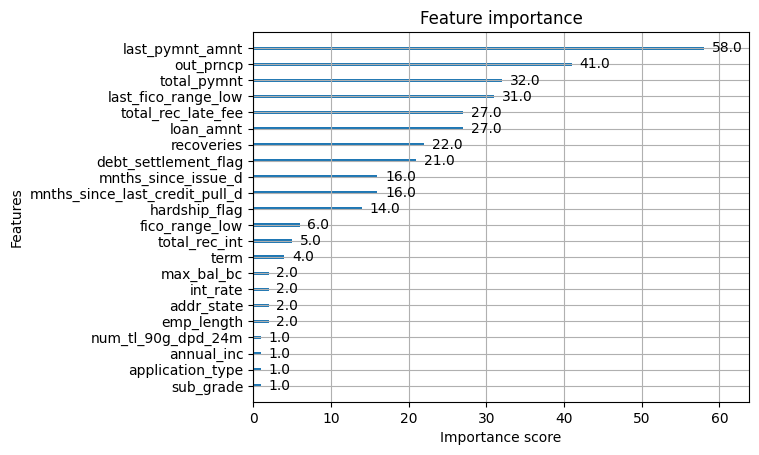

In [88]:
xgb.plot_importance(xgb_logreg)

In [89]:
y_pred = xgb_logreg.predict(test_loans_dmatrix)

In [90]:
roc_auc_score(y_test, y_pred)

0.9944301923381602

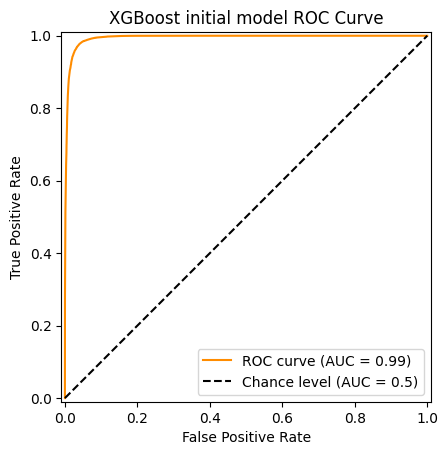

In [91]:
display = RocCurveDisplay.from_predictions(
    y_test,
    y_pred,
    name=f"ROC curve",
    color="darkorange",
    plot_chance_level=True,
)

display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="XGBoost initial model ROC Curve",
)

plt.show()

In [92]:
cm_initial = confusion_matrix(y_test, y_pred.round())

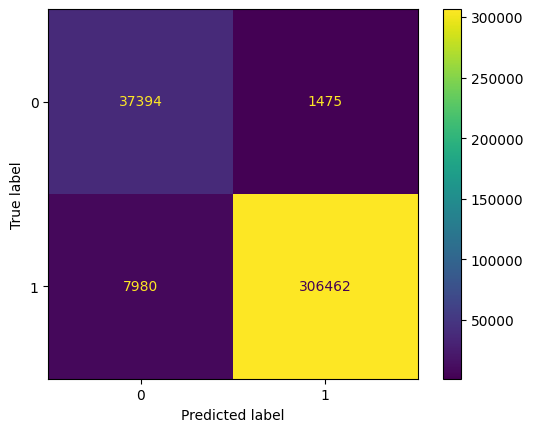

In [93]:
ConfusionMatrixDisplay(cm_initial).plot()

In [94]:
print(f"Model specifity: {(cm_initial[0][0] / (cm_initial[0][0] + cm_initial[0][1])).round(3)}")

Model specifity: 0.962


In [95]:
print(f"Model sensitivity: {(cm_initial[1][1] / (cm_initial[1][1] + cm_initial[1][0])).round(3)}")

Model sensitivity: 0.975


### **4.3 Features selection and final XGBoost model**

In [96]:
scores = pd.DataFrame({
    "feature": xgb_logreg.get_score().keys(),
    "importance_score": xgb_logreg.get_score().values()
})

In [97]:
scores.sort_values("importance_score", ascending=False)

,feature,importance_score
16,last_pymnt_amnt,58.0
11,out_prncp,41.0
12,total_pymnt,32.0
17,last_fico_range_low,31.0
6,loan_amnt,27.0
14,total_rec_late_fee,27.0
15,recoveries,22.0
5,debt_settlement_flag,21.0
20,mnths_since_last_credit_pull_d,16.0
21,mnths_since_issue_d,16.0


In [165]:
parameters = pd.DataFrame({
    "imp_score_th": [1, 5, 16],
    "gamma": [10, 100, 1000],
    "eta": [0.4, 0.6, 0.8],
    "max_depth": [3, 4, 5],
    "train-mean-accuracy": [np.nan for _ in range(3)],
    "test-mean-accuracy": [np.nan for _ in range(3)],
    "test-split-accuracy": [np.nan for _ in range(3)]
})

In [166]:
parameters_comb = pd.DataFrame(
    product(
        parameters["imp_score_th"], 
        parameters["gamma"], 
        parameters["eta"],
        parameters["max_depth"]
    ),
    columns=["imp_score_th", "gamma", "eta", "max_depth"]
)

In [167]:
param_iter = zip(parameters_comb["imp_score_th"], parameters_comb["gamma"], parameters_comb["eta"], parameters_comb["max_depth"])

In [168]:
param_scores = {
    "imp_score_th": [],
    "gamma": [],
    "eta": [],
    "max_depth": [],
    "train-mean-auc": [],
    "train-mean-std": [],
    "test-mean-auc": [],
    "test-mean-std": [],
    "test-split-accuracy": [],
    "precision": [],
    "recall": [],
    "specifity": [],
    "f1-score": [],
    "cc-rmse": []
}

In [169]:
def calc_cc_rmse(y_t, y_p):
    diff = (y_t - y_p) ** 2
    return np.sqrt((np.sum(diff) / diff.size)).round(2)

In [170]:
for imp_score_th, gamma, eta, max_depth in param_iter:
    important_features = [feature for feature in xgb_logreg.get_score() if xgb_logreg.get_score()[feature] > imp_score_th]
    X_imp = X[important_features]
    X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=12, stratify=y)
    X_train_y_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    count_nondefault, count_default = X_train_y_train["good_bad"].value_counts()
    nondefaults = X_train_y_train[X_train_y_train["good_bad"] == 1]
    defaults = X_train_y_train[X_train_y_train["good_bad"] == 0]
    nondefaults_sample = nondefaults.sample(n=count_default)
    X_y_train_under = pd.concat([nondefaults_sample.reset_index(drop=True), defaults.reset_index(drop=True)], axis=0)
    X_train = X_y_train_under.drop(columns=["good_bad"])
    y_train = X_y_train_under.loc[:, "good_bad"]
    
    for col in X_train.columns.values:
        if X_train[col].dtypes == "object":
            X_train[col] = X_train[col].astype("category")
    for col in X_test.columns.values:
        if X_test[col].dtypes == "object":
            X_test[col] = X_test[col].astype("category")
    train_loans_dmatrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
    test_loans_dmatrix = xgb.DMatrix(data=X_test, enable_categorical=True)
    params = {
        "objective":"binary:logistic",
        "gamma": gamma,
        "eta": eta,
        "max_depth": max_depth
    }
    cv_score_features_xgb = xgb.cv(
    params=params, 
    dtrain=train_loans_dmatrix, 
    shuffle = True, 
    nfold = 3,
    metrics = "auc",
    num_boost_round = 5,
    early_stopping_rounds = 5,
    seed = 11
)
    param_scores["imp_score_th"].append(imp_score_th)
    param_scores["gamma"].append(gamma)
    param_scores["eta"].append(eta)
    param_scores["max_depth"].append(max_depth)
    param_scores["train-mean-auc"].append(cv_score_features_xgb["train-auc-mean"].mean().round(4))
    param_scores["test-mean-auc"].append(cv_score_features_xgb["test-auc-mean"].mean().round(4))
    param_scores["train-mean-std"].append(cv_score_features_xgb["train-auc-std"].mean().round(4))
    param_scores["test-mean-std"].append(cv_score_features_xgb["test-auc-std"].mean().round(4))
    
    xgb_temp = xgb.train(dtrain=train_loans_dmatrix, params=params)
    y_pred = xgb_temp.predict(test_loans_dmatrix)
    
    frac_pos, mean_proba = calibration_curve(y_test, y_pred, n_bins=20)
    param_scores["cc-rmse"].append(calc_cc_rmse(frac_pos, mean_proba))
    conf_matr_temp = confusion_matrix(y_test, y_pred.round())
    
    precision = (conf_matr_temp[1][1] / (conf_matr_temp[1][1] + conf_matr_temp[0][1])).round(3)
    recall = (conf_matr_temp[1][1] / (conf_matr_temp[1][1] + conf_matr_temp[1][0])).round(3)
    specifity = (conf_matr_temp[0][0] / (conf_matr_temp[0][0] + conf_matr_temp[0][1])).round(3)
    param_scores["precision"].append(precision)
    param_scores["recall"].append(recall)
    param_scores["specifity"].append(specifity)
    param_scores["f1-score"].append(2 * ((precision * recall) / (precision + recall)))
    param_scores["test-split-accuracy"].append(roc_auc_score(y_test, y_pred).round(3))

In [171]:
scores = pd.DataFrame(param_scores)

In [172]:
scores.sort_values(["f1-score", "train-mean-auc", "test-mean-auc", "test-split-accuracy"], ascending=False).head(10)

,imp_score_th,gamma,eta,max_depth,train-mean-auc,train-mean-std,test-mean-auc,test-mean-std,test-split-accuracy,precision,recall,specifity,f1-score,cc-rmse
44,5,100,0.8,5,0.9890,0.0003,0.9888,0.0003,0.996,0.996,0.982,0.968,0.988950,0.33
32,5,10,0.6,5,0.9888,0.0002,0.9887,0.0002,0.996,0.996,0.982,0.966,0.988950,0.31
8,1,10,0.8,5,0.9894,0.0003,0.9892,0.0003,0.996,0.996,0.981,0.969,0.988443,0.33
14,1,100,0.6,5,0.9886,0.0002,0.9885,0.0002,0.995,0.996,0.981,0.965,0.988443,0.31
35,5,10,0.8,5,0.9894,0.0004,0.9892,0.0003,0.996,0.996,0.980,0.969,0.987935,0.33
62,16,10,0.8,5,0.9893,0.0002,0.9891,0.0004,0.995,0.996,0.980,0.967,0.987935,0.33
5,1,10,0.6,5,0.9888,0.0002,0.9887,0.0002,0.996,0.996,0.980,0.966,0.987935,0.31
41,5,100,0.6,5,0.9886,0.0002,0.9885,0.0002,0.995,0.996,0.980,0.965,0.987935,0.32
17,1,100,0.8,5,0.9890,0.0003,0.9888,0.0004,0.996,0.996,0.979,0.968,0.987427,0.33
34,5,10,0.8,4,0.9861,0.0005,0.9860,0.0004,0.995,0.996,0.979,0.967,0.987427,0.33


In [173]:
scores.sort_values(["f1-score", "specifity", "train-mean-auc", "test-mean-auc", "test-split-accuracy"], ascending=True).head(10)

,imp_score_th,gamma,eta,max_depth,train-mean-auc,train-mean-std,test-mean-auc,test-mean-std,test-split-accuracy,precision,recall,specifity,f1-score,cc-rmse
72,16,1000,0.4,3,0.9672,0.0003,0.9671,0.0004,0.988,0.992,0.963,0.938,0.977285,0.33
18,1,1000,0.4,3,0.9678,0.0003,0.9678,0.0004,0.989,0.992,0.964,0.938,0.977800,0.34
45,5,1000,0.4,3,0.9678,0.0003,0.9678,0.0004,0.989,0.992,0.964,0.938,0.977800,0.34
54,16,10,0.4,3,0.9763,0.0014,0.9763,0.0012,0.990,0.992,0.965,0.939,0.978314,0.33
63,16,100,0.4,3,0.9763,0.0014,0.9763,0.0012,0.990,0.992,0.965,0.939,0.978314,0.33
25,1,1000,0.8,4,0.9761,0.0012,0.9759,0.0014,0.992,0.995,0.964,0.959,0.979255,0.33
80,16,1000,0.8,5,0.9759,0.0008,0.9759,0.0007,0.990,0.995,0.964,0.963,0.979255,0.33
22,1,1000,0.6,4,0.9740,0.0014,0.9739,0.0014,0.991,0.994,0.965,0.949,0.979285,0.32
19,1,1000,0.4,4,0.9681,0.0007,0.9681,0.0009,0.991,0.993,0.966,0.943,0.979314,0.34
46,5,1000,0.4,4,0.9681,0.0007,0.9681,0.0009,0.991,0.993,0.966,0.943,0.979314,0.34


In [182]:
important_features = [feature for feature in xgb_logreg.get_score() if xgb_logreg.get_score()[feature] > 5]
X_imp = X[important_features]
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=12, stratify=y)
X_train_y_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
count_nondefault, count_default = X_train_y_train["good_bad"].value_counts()
nondefaults = X_train_y_train[X_train_y_train["good_bad"] == 1]
defaults = X_train_y_train[X_train_y_train["good_bad"] == 0]
nondefaults_sample = nondefaults.sample(n=count_default)
X_y_train_under = pd.concat([nondefaults_sample.reset_index(drop=True), defaults.reset_index(drop=True)], axis=0)
X_train = X_y_train_under.drop(columns=["good_bad"])
y_train = X_y_train_under.loc[:, "good_bad"]

for col in X_train.columns.values:
    if X_train[col].dtypes == "object":
        X_train[col] = X_train[col].astype("category")
for col in X_test.columns.values:
    if X_test[col].dtypes == "object":
        X_test[col] = X_test[col].astype("category")
train_loans_dmatrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
test_loans_dmatrix = xgb.DMatrix(data=X_test, enable_categorical=True)
params = {
    "objective":"binary:logistic",
    "gamma": 10,
    "eta": 0.6,
    "max_depth": 5
}
cv_score_final_xgb = xgb.cv(
    params=params, 
    dtrain=train_loans_dmatrix, 
    shuffle = True, 
    nfold = 3,
    metrics = "auc",
    num_boost_round = 5,
    early_stopping_rounds = 5,
    seed = 22
)

In [183]:
len(X_imp.columns.values)

12

In [196]:
cv_score_final_xgb

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.981231,0.000347,0.980963,0.000337
1,0.986582,0.001987,0.986383,0.002222
2,0.990286,0.000013,0.990132,0.000022
3,0.991125,0.000031,0.990926,0.000027
4,0.991911,0.000128,0.991733,0.000154


In [197]:
print(f"Cross validation train split mean auc: {cv_score_final_xgb["train-auc-mean"].mean().round(4)} and std {cv_score_final_xgb["train-auc-mean"].std(ddof=0).round(4)}")
print(f"Cross validation train split mean standard deviation: {cv_score_final_xgb["train-auc-std"].mean().round(4)}")
print(f"Cross validation test split mean auc: {cv_score_final_xgb["test-auc-mean"].mean().round(4)} and std {cv_score_final_xgb["test-auc-mean"].std(ddof=0).round(4)}")
print(f"Cross validation test split mean standard deviation: {cv_score_final_xgb["test-auc-std"].mean().round(4)}")

Cross validation train split mean auc: 0.9882 and std 0.0039
Cross validation train split mean standard deviation: 0.0005
Cross validation test split mean auc: 0.988 and std 0.004
Cross validation test split mean standard deviation: 0.0006


In [186]:
xgb_fin = xgb.train(dtrain=train_loans_dmatrix, params=params)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

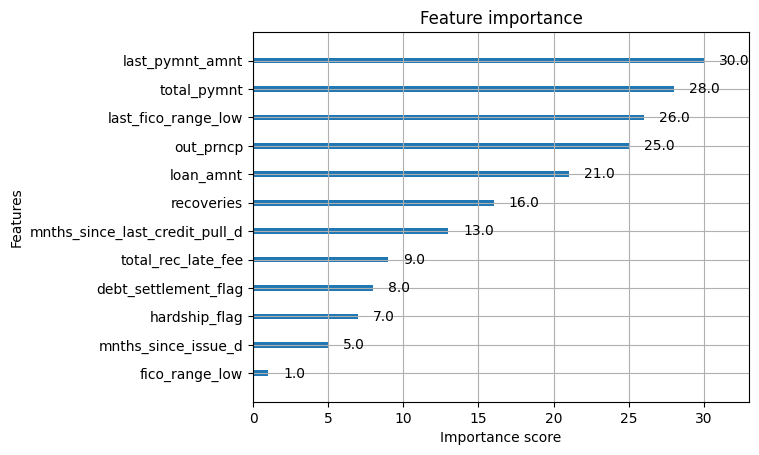

In [187]:
xgb.plot_importance(xgb_fin)

In [188]:
y_pred = xgb_fin.predict(test_loans_dmatrix)

In [189]:
roc_auc_score(y_test, y_pred)

0.9955486986742013

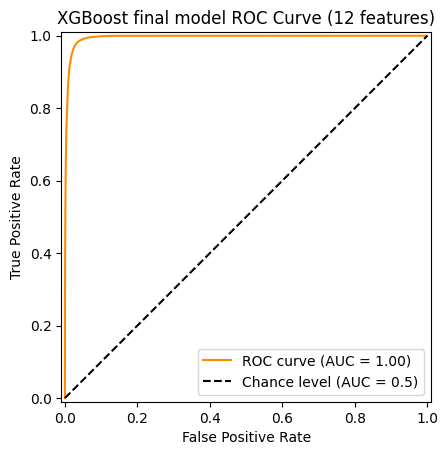

In [190]:
display = RocCurveDisplay.from_predictions(
    y_test,
    y_pred,
    name=f"ROC curve",
    color="darkorange",
    plot_chance_level=True,
)

display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="XGBoost final model ROC Curve (12 features)",
)

plt.show()

In [191]:
cm_final = confusion_matrix(y_test, y_pred.round())

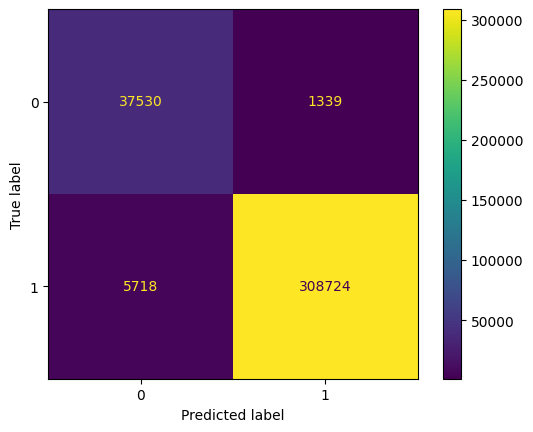

In [192]:
ConfusionMatrixDisplay(cm_final).plot()

In [198]:
print(f"Model specifity: {(cm_final[0][0] / (cm_final[0][0] + cm_final[0][1])).round(3)}")

Model specifity: 0.966


In [199]:
print(f"Model sensitivity: {(cm_final[1][1] / (cm_final[1][1] + cm_final[1][0])).round(3)}")

Model sensitivity: 0.982


## **4.7 Model calibration**

In [123]:
loans["good_bad"].value_counts(normalize=True)

good_bad
1    0.889986
0    0.110014
Name: proportion, dtype: float64

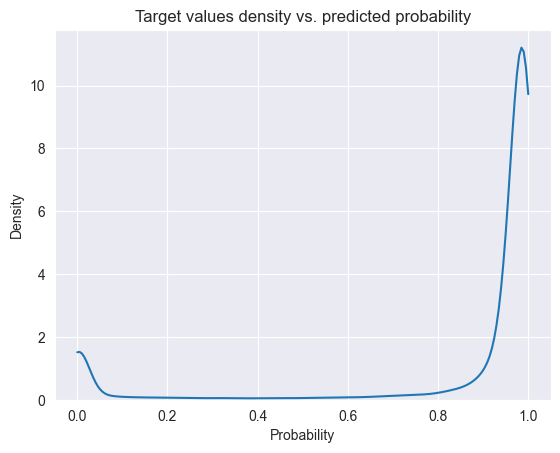

In [204]:
with sns.axes_style("darkgrid"):
    sns.kdeplot(y_pred, cut=0, common_norm=True)
    plt.title("Target values density vs. predicted probability")
    plt.xlabel("Probability")
    plt.show()

In [208]:
(y_pred[(y_pred > 0.1) & (y_pred < 0.7)].size) / y_pred.size

0.03876754474103552

# **5 Credit acceptance rate and Estimated Value**

In [145]:
reject_rate = np.arange(0.02, 1.0, 0.02)
thresholds = []
bad_rates = []
num_loans = []

In [146]:
for rate in reject_rate:
    threshold = np.quantile(y_pred, rate).round(3)
    thresholds.append(threshold)
    y_pred_th = np.where(y_pred >= threshold, 1, 0)
    y_reduced = y_pred[y_pred_th == 1]
    bad_rate = ((y_reduced.size - np.sum(y_reduced)) / y_reduced.size).round(3)
    bad_rates.append(bad_rate)
    num_loans.append(y_reduced.size)

In [147]:
strategy_table = pd.DataFrame(zip(reject_rate, thresholds, bad_rates, num_loans), columns=["reject_rate", "threshold", "bad_rate", "num_accepted_loans"])

In [148]:
strategy_table["avg_loan_amnt"] = loans_backup["loan_amnt"].mean().round(2)

In [149]:
strategy_table["estimated_value"] = (
    (strategy_table["num_accepted_loans"] * (1 - strategy_table["bad_rate"]) * strategy_table["avg_loan_amnt"]) - \
    (strategy_table["num_accepted_loans"] * strategy_table["bad_rate"] * strategy_table["avg_loan_amnt"])
).round(2)

In [ ]:
strategy_table.sort_values("

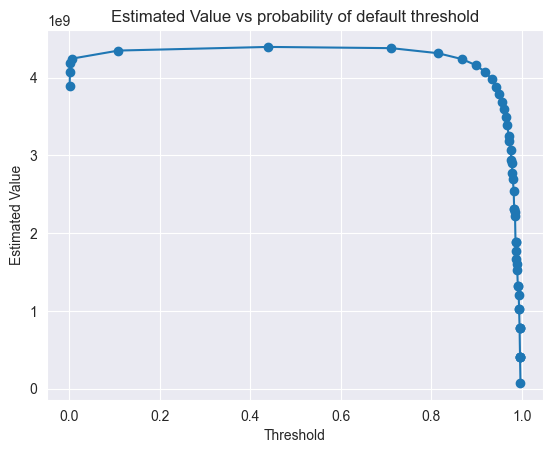

In [150]:
with sns.axes_style("darkgrid"):
    plt.plot(strategy_table["threshold"], strategy_table["estimated_value"], marker="o", )
    plt.title("Estimated Value vs probability of default threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Estimated Value")
    plt.show()

In [151]:
strategy_table[strategy_table["estimated_value"] == strategy_table["estimated_value"].max()]

,reject_rate,threshold,bad_rate,num_accepted_loans,avg_loan_amnt,estimated_value
5,0.12,0.44,0.04,310914,15358.78,4.393239e+09


Best esimated value is when threshold is equal to 0.433, although all thresholds between 0.05 and 0.7 give very similair results.

In [152]:
y_th_05 = np.where(y_pred >= 0.5, 1, 0)

In [153]:
y_reduced_05 = y_pred[y_th_05 == 1]

In [154]:
bad_rate_05 = ((y_reduced_05.size - np.sum(y_reduced_05)) / y_reduced_05.size).round(3)

In [155]:
bad_rate_05

0.038

In [156]:
num_accepted_05 = y_reduced_05.size

In [157]:
ev_05 = ((num_accepted_05 * (1 - bad_rate_05) * loans["loan_amnt"].mean().round(2)) - \
    (num_accepted_05 * bad_rate_05 * loans["loan_amnt"].mean().round(2))
).round(2)

In [158]:
ev_05

4473080855.81